# Dynamic Time Warping

In [81]:
import pandas as pd
import numpy as np
import plotly.offline as pyo
import plotly.graph_objs as go
pyo.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt

import os

from sklearn.preprocessing import minmax_scale

### Definindo período para análises

In [47]:
all_bets = pd.DataFrame(index=pd.date_range(start = '1980-01-01', end = '2019-01-01', freq='MS'))

for i in os.listdir('../data/raw/bets/'):
    name = i.split('.')[0]
    temp_df = pd.read_csv('../data/raw/bets/'+i, index_col=0)
    temp_df.set_index('date', inplace=True)
    temp_df.columns = [name]
    
    all_bets = df.merge(temp_df, left_index = True, right_index = True, how = 'left')

# pd.read_csv('../data/raw/bets/*', index_col=0, encoding='latin1')

- Obs: com exceção do ANEEL, todos os outros datasets estão padronizados. Portanto vou testar inicialmente sem os dados coletados na ANEEL.

Teoricamente, o meu período ideal seria min < 2001 e max >= 2010.

- Verificando as series que atendem a essa condição

In [67]:
df_cond = all_bets[(all_bets.index >= '2001-01-01') & (all_bets.index <= '2010-01-01')].dropna(axis=1)

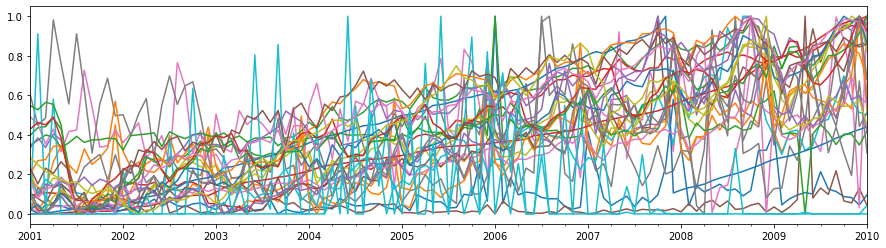

In [83]:
df_cond.apply(minmax_scale).plot(legend = False, figsize = (15,4))

In [93]:
list_df = []
for i in [i for i in os.listdir('../data/') if i.endswith('.csv')]:
    name = i.split('.')[0].upper()
    temp_df = pd.read_csv('../data/'+i, index_col=0, encoding='latin1')
    temp_df['grupo'] = name
    list_df.append(temp_df)

dict_df = pd.concat(list_df)

- Séries para teste inicial definidas!!!!

# Implementando DTW

## Pré tratamento

In [132]:
analysis_dfs = dates[cond1 & cond2]
list_to_dtw =[]
for chunk in np.unique(analysis_dfs['chunk']):
    temp_df = analysis_dfs[analysis_dfs['chunk'] == chunk]
    for c in temp_df['code']:
        temp_df2 = pd.read_csv('./'+chunk+'/data/'+c+'.csv', index_col=0, encoding='latin1')
        # Definindo o corte min < 2000 e max > 2010
        list_to_dtw.append(temp_df2[(temp_df2['date'] >= '2001-01-01') & (temp_df2['date'] <= '2010-01-01')])

- Plot pré padronização

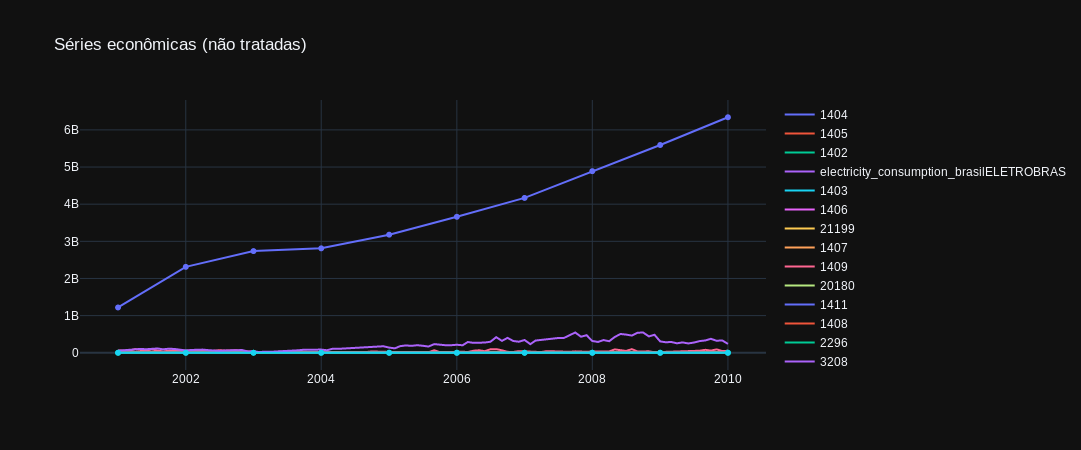

In [134]:
data = []
for i in range(len(list_to_dtw)):
    x = list_to_dtw[i]['date']
    y = list_to_dtw[i][list_to_dtw[i].columns[-1]]
    code = analysis_dfs.code.tolist()[i]
    trace = go.Scatter(x = x, y = y, name = code)
    data.append(trace)

layout = go.Layout(title = 'Séries econômicas (não tratadas)',
                   xaxis = dict(type = 'date'),
                   template  = 'plotly_dark')
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig, filename = './series_naotratadas.html',config=dict(showLink = False))

- Plot padronizadas

In [135]:
def normalize_list_numpy(ts):
    normalized_list = (ts - min(ts))/(max(ts)-min(ts))
    return normalized_list

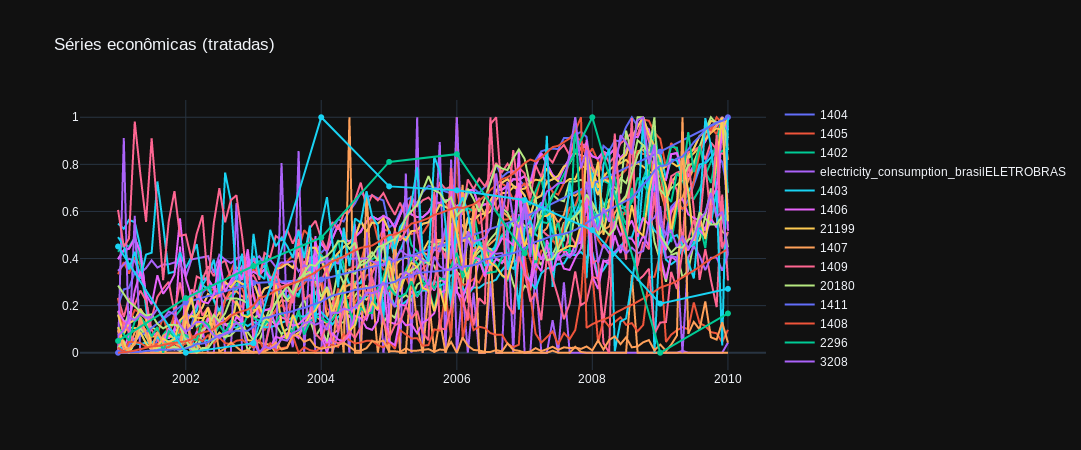

In [136]:
data = []
for i in range(len(list_to_dtw)):
    x = list_to_dtw[i]['date']
    y = normalize_list_numpy(list_to_dtw[i][list_to_dtw[i].columns[-1]])
    code = analysis_dfs.code.tolist()[i]
    trace = go.Scatter(x = x, y = y, name = code)
    data.append(trace)

layout = go.Layout(title = 'Séries econômicas (tratadas)',
                   xaxis = dict(type = 'date'),
                   template  = 'plotly_dark')
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig, filename = './series_tratadas.html',config=dict(showLink = False))

# Matriz de dissimilaridade

In [160]:
%%time
from tslearn.metrics import dtw

matrix_dissimilaridade = pd.DataFrame()

for i in range(len(list_to_dtw)):
    list_col = []
    value_coli = list_to_dtw[i].columns[-1]
    for j in range(len(list_to_dtw)):
        value_colj = list_to_dtw[j].columns[-1]
        ts1 = normalize_list_numpy(list_to_dtw[i][value_coli].values)
        ts2 = normalize_list_numpy(list_to_dtw[j][value_colj].values)
        dissimilaridade = dtw(ts1, ts2)
        list_col.append(dissimilaridade)
    matrix_dissimilaridade[str(i)] = list_col

CPU times: user 16.3 s, sys: 0 ns, total: 16.3 s
Wall time: 16.3 s


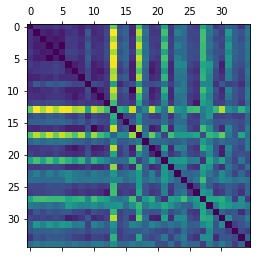

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.matshow(matrix_dissimilaridade)

### Reduzindo as dimensões com MDS (Multi Dimensional Scaling)


In [163]:
from sklearn.manifold import MDS

mds_scaler = MDS(n_components = 2)
dissimilaridade_scaled = mds_scaler.fit_transform(matrix_dissimilaridade)

/home/breno/.virtualenvs/dtsci/lib/python3.6/site-packages/sklearn/manifold/mds.py:421: UserWarning:

The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.



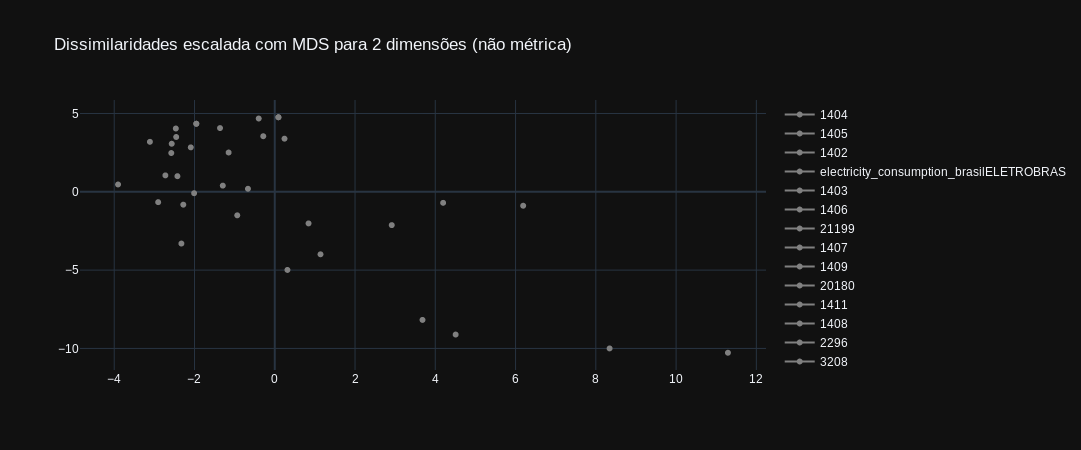

In [166]:
data = []
for i in range(len(dissimilaridade_scaled)):
    trace = go.Scatter(x = [dissimilaridade_scaled[i][0]],
                       y = [dissimilaridade_scaled[i][1]],
                       name = analysis_dfs.code.tolist()[i],
                       marker = dict(color = 'gray'))
    data.append(trace)
layout = go.Layout(title = 'Dissimilaridades escalada com MDS para 2 dimensões (não métrica)',
                   template = 'plotly_dark')
fig = go.Figure(data = data, layout=layout)
pyo.iplot(fig, config=dict(showLink = False))

### Clusterizando (K-Means)

In [167]:
from sklearn.cluster import KMeans, ward_tree

kmeans_cluster = KMeans(n_clusters=5, random_state=0).fit(dissimilaridade_scaled)

labels = kmeans_cluster.labels_

dissimilaridade_kmeans = pd.DataFrame(dissimilaridade_scaled)
dissimilaridade_kmeans['cluster'] = labels.tolist()
dissimilaridade_kmeans.columns = ['x','y','cluster']

In [184]:
# Adicionando coluna de codes e chunk
dissimilaridade_kmeans['chunk'] = analysis_dfs['chunk'].tolist()
dissimilaridade_kmeans['code'] = analysis_dfs['code'].tolist()

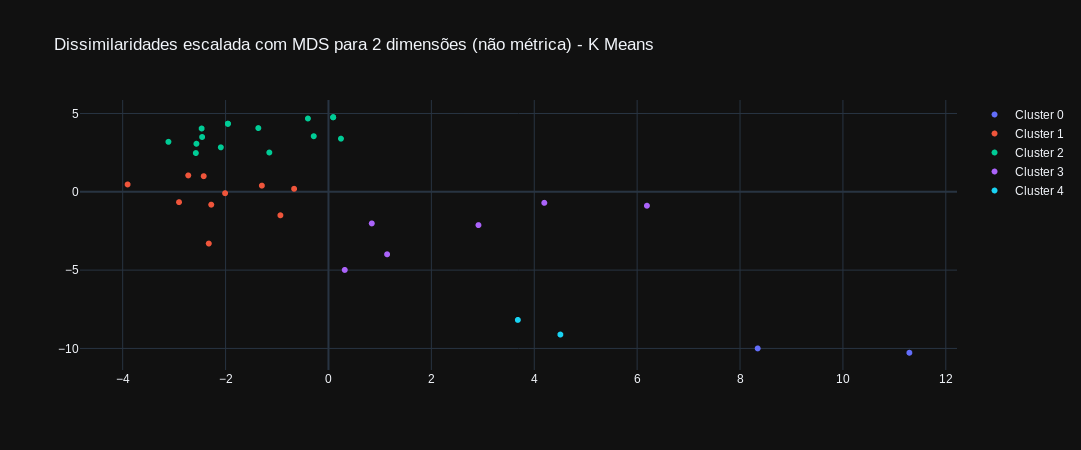

In [174]:
data = []
for i in range(0,5):
    temp_df = dissimilaridade_kmeans[dissimilaridade_kmeans['cluster'] == i]
    trace = go.Scatter(x = temp_df['x'],
                       y = temp_df['y'],
                       name = 'Cluster '+str(i),
                       mode = 'markers')
    data.append(trace)
layout = go.Layout(title = 'Dissimilaridades escalada com MDS para 2 dimensões (não métrica) - K Means',
                   template = 'plotly_dark')
fig = go.Figure(data = data, layout=layout)
pyo.iplot(fig, config=dict(showLink = False))

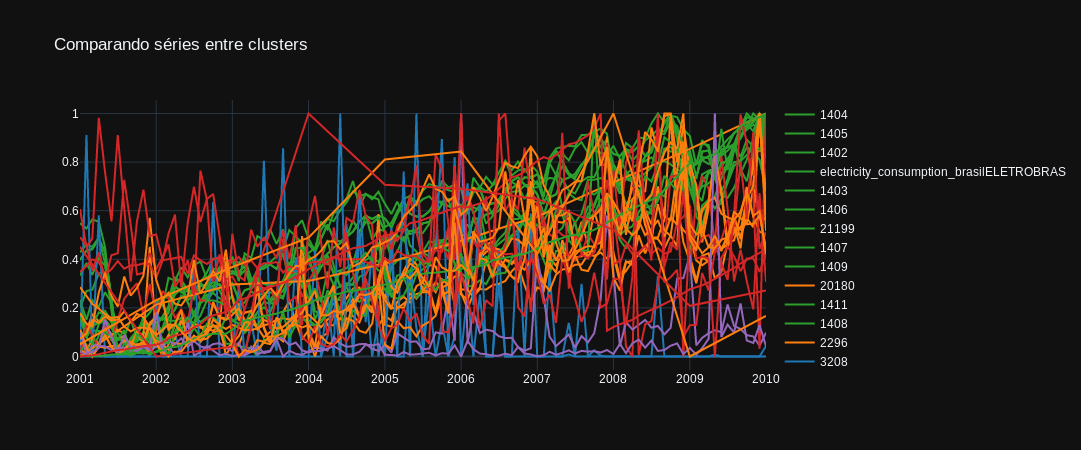

In [208]:
i = 0
data = []
color_list =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for c in dissimilaridade_kmeans.cluster.values:
    temp_df = list_to_dtw[i]
    trace = go.Scatter(x = temp_df['date'], y = normalize_list_numpy(temp_df[temp_df.columns[-1]]),
                       name = analysis_dfs['code'].tolist()[i],
                       mode = 'lines', marker = dict(color = color_list[c]))
    data.append(trace)
    i += 1
    
layout = go.Layout(title = 'Comparando séries entre clusters', template = 'plotly_dark')
fig = go.Figure(data=data, layout = layout)
pyo.iplot(fig, config=dict(showLink = False))

## Análise dos agrupamentos

In [213]:
# Cluster 0
c0 = dissimilaridade_kmeans[dissimilaridade_kmeans['cluster'] == 0]
c0

,x,y,cluster,chunk,code
13,11.292443,-10.276399,0,NORTE,3208
17,8.343456,-10.000850,0,NORTE,3440


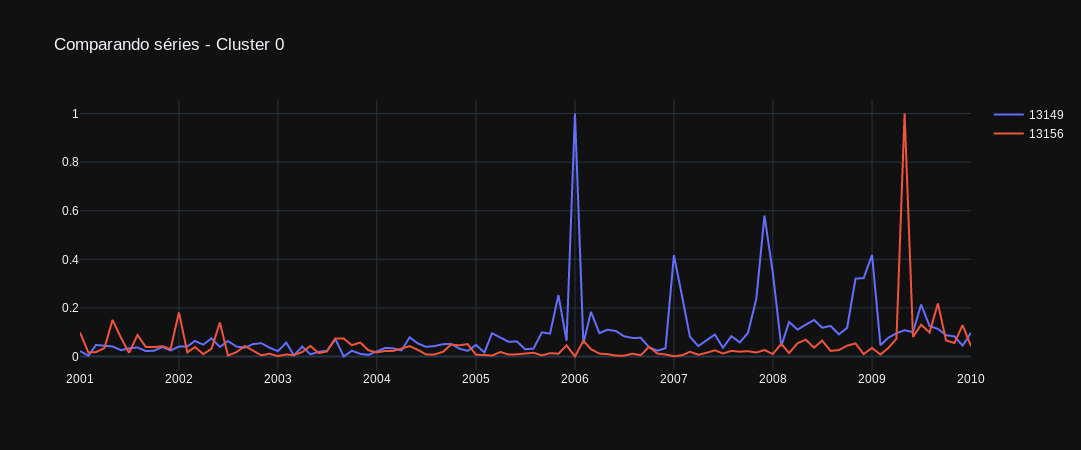

In [228]:
cluster = '0'
cluster_df = c0
###
data0 = []
color_list =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i in cluster_df.index:
    temp_df = list_to_dtw[i]
    trace = go.Scatter(x = temp_df['date'],
                       y = normalize_list_numpy(temp_df[temp_df.columns[-1]]),
                       name = cluster_df['code'][i],
                       mode = 'lines')#, marker = dict(color = color_list[c]))
    data0.append(trace)
    
layout = go.Layout(title = 'Comparando séries - Cluster '+cluster, template = 'plotly_dark')
fig = go.Figure(data=data, layout = layout)
pyo.iplot(fig, config=dict(showLink = False))

In [218]:
# Cluster 1
c1 = dissimilaridade_kmeans[dissimilaridade_kmeans['cluster'] == 1]
c1

,x,y,cluster,chunk,code
9,-2.278786,-0.820461,1,NORTE,20180
12,-2.424989,0.999595,1,NORTE,2296
14,-2.904849,-0.659620,1,NORTE,2290
15,-0.934396,-1.499810,1,NORTE,21186
20,-3.904656,0.469504,1,RORAIMA,12528
25,-1.294824,0.394830,1,RORAIMA,1459
26,-2.725477,1.047875,1,RORAIMA,4358
29,-0.667860,0.194435,1,VENEZUELA,7767
32,-2.326486,-3.303036,1,VENEZUELA,7760
33,-2.009122,-0.087133,1,VENEZUELA,3301


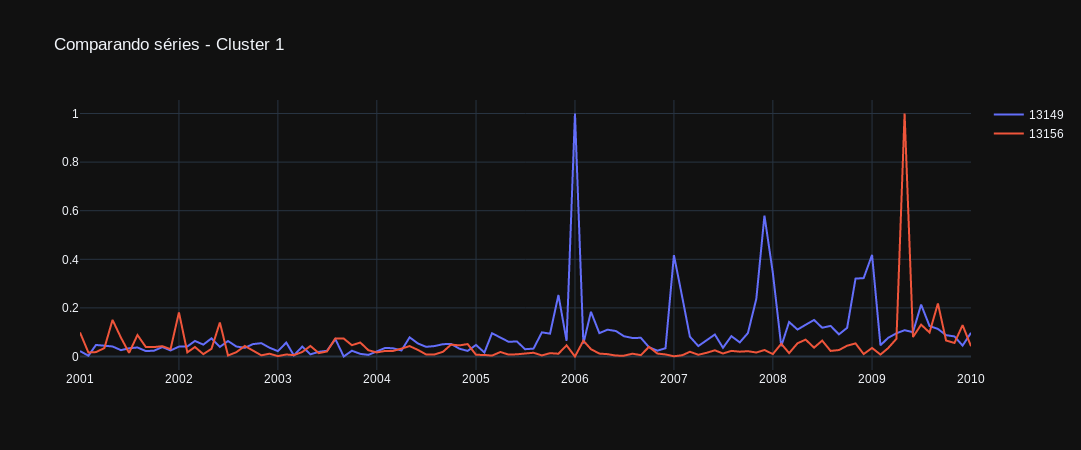

In [229]:
cluster = '1'
cluster_df = c1
###
data1 = []
color_list =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i in cluster_df.index:
    temp_df = list_to_dtw[i]
    trace = go.Scatter(x = temp_df['date'],
                       y = normalize_list_numpy(temp_df[temp_df.columns[-1]]),
                       name = cluster_df['code'][i],
                       mode = 'lines')#, marker = dict(color = color_list[c]))
    data1.append(trace)
    
layout = go.Layout(title = 'Comparando séries - Cluster '+cluster, template = 'plotly_dark')
fig = go.Figure(data=data, layout = layout)
pyo.iplot(fig, config=dict(showLink = False))

In [222]:
# Cluster 2
c2 = dissimilaridade_kmeans[dissimilaridade_kmeans['cluster'] == 2]
c2

,x,y,cluster,chunk,code
0,-1.149448,2.509343,2,BRASIL,1404
1,-0.399731,4.681352,2,BRASIL,1405
2,-0.286253,3.551033,2,BRASIL,1402
3,0.091534,4.761822,2,BRASIL,electricity_consumption_brasilELETROBRAS
4,0.242536,3.394133,2,BRASIL,1403
5,0.091534,4.761822,2,BRASIL,1406
6,-2.465151,4.043190,2,NORTE,21199
7,-2.566800,3.069522,2,NORTE,1407
8,-1.363912,4.070177,2,NORTE,1409
10,-1.954521,4.347188,2,NORTE,1411


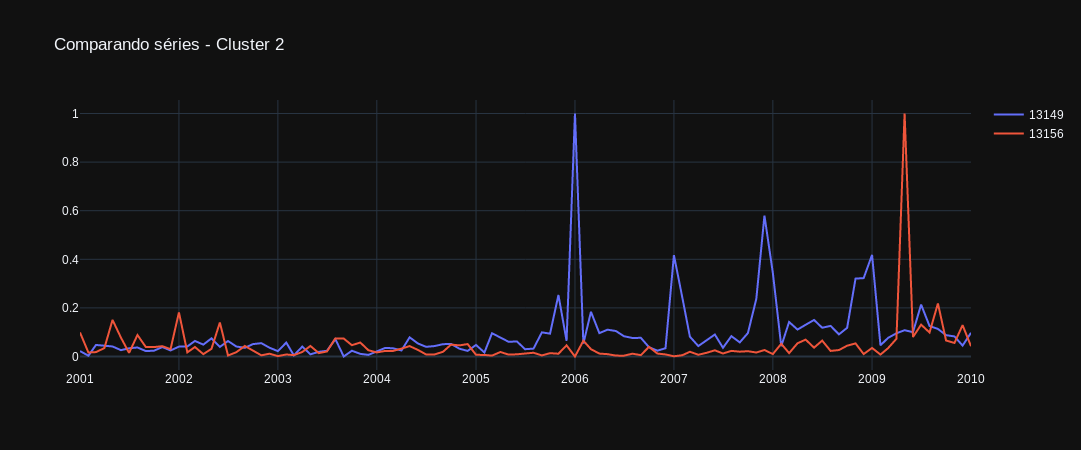

In [230]:
cluster = '2'
cluster_df = c2
###
data2 = []
color_list =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i in cluster_df.index:
    temp_df = list_to_dtw[i]
    trace = go.Scatter(x = temp_df['date'],
                       y = normalize_list_numpy(temp_df[temp_df.columns[-1]]),
                       name = cluster_df['code'][i],
                       mode = 'lines')#, marker = dict(color = color_list[c]))
    data2.append(trace)
    
layout = go.Layout(title = 'Comparando séries - Cluster '+cluster, template = 'plotly_dark')
fig = go.Figure(data=data, layout = layout)
pyo.iplot(fig, config=dict(showLink = False))

In [224]:
# Cluster 3
c3 = dissimilaridade_kmeans[dissimilaridade_kmeans['cluster'] == 3]
c3

,x,y,cluster,chunk,code
18,0.841938,-2.016973,3,NORTE,20181
23,2.915257,-2.125648,3,RORAIMA,12601
24,4.195397,-0.702864,3,RORAIMA,12576
28,6.189985,-0.888059,3,VENEZUELA,3533
31,0.316375,-4.988504,3,VENEZUELA,7733
34,1.139758,-3.989907,3,VENEZUELA,7712


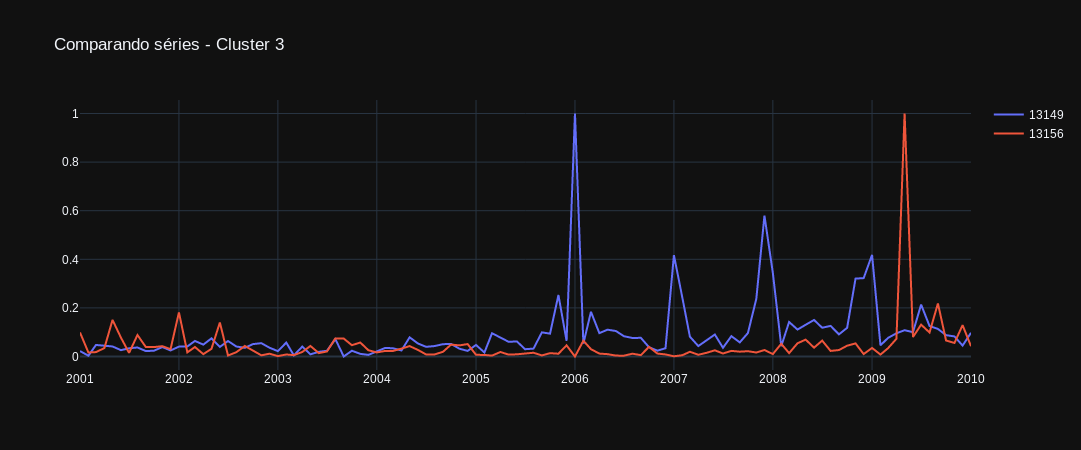

In [231]:
cluster = '3'
cluster_df = c3
###
data3 = []
color_list =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i in cluster_df.index:
    temp_df = list_to_dtw[i]
    trace = go.Scatter(x = temp_df['date'],
                       y = normalize_list_numpy(temp_df[temp_df.columns[-1]]),
                       name = cluster_df['code'][i],
                       mode = 'lines')#, marker = dict(color = color_list[c]))
    data3.append(trace)
    
layout = go.Layout(title = 'Comparando séries - Cluster '+cluster, template = 'plotly_dark')
fig = go.Figure(data=data, layout = layout)
pyo.iplot(fig, config=dict(showLink = False))

In [226]:
# Cluster 4
c4 = dissimilaridade_kmeans[dissimilaridade_kmeans['cluster'] == 4]
c4

,x,y,cluster,chunk,code
21,3.681268,-8.179425,4,RORAIMA,13149
27,4.507796,-9.114078,4,RORAIMA,13156


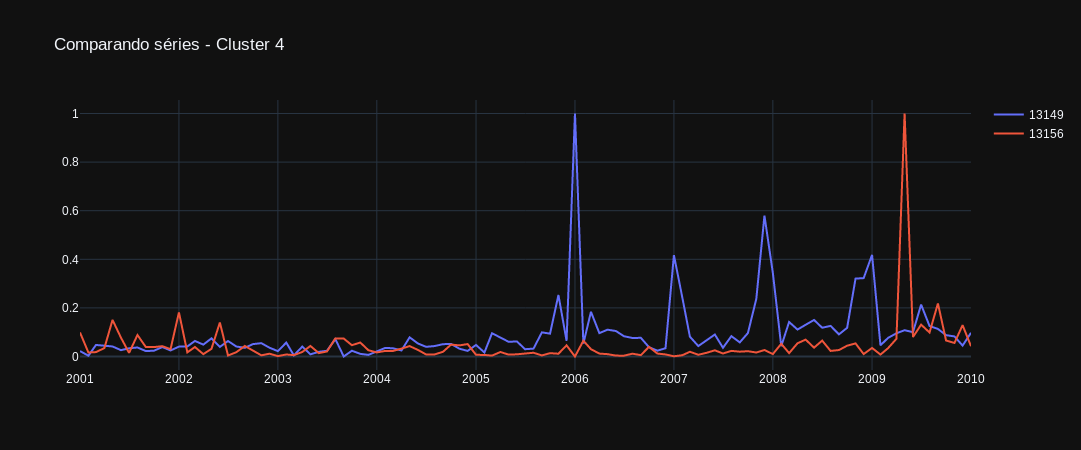

In [232]:
cluster = '4'
cluster_df = c4
###
data4 = []
color_list =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i in cluster_df.index:
    temp_df = list_to_dtw[i]
    trace = go.Scatter(x = temp_df['date'],
                       y = normalize_list_numpy(temp_df[temp_df.columns[-1]]),
                       name = cluster_df['code'][i],
                       mode = 'lines')#, marker = dict(color = color_list[c]))
    data4.append(trace)
    
layout = go.Layout(title = 'Comparando séries - Cluster '+cluster, template = 'plotly_dark')
fig = go.Figure(data=data, layout = layout)
pyo.iplot(fig, config=dict(showLink = False))

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]



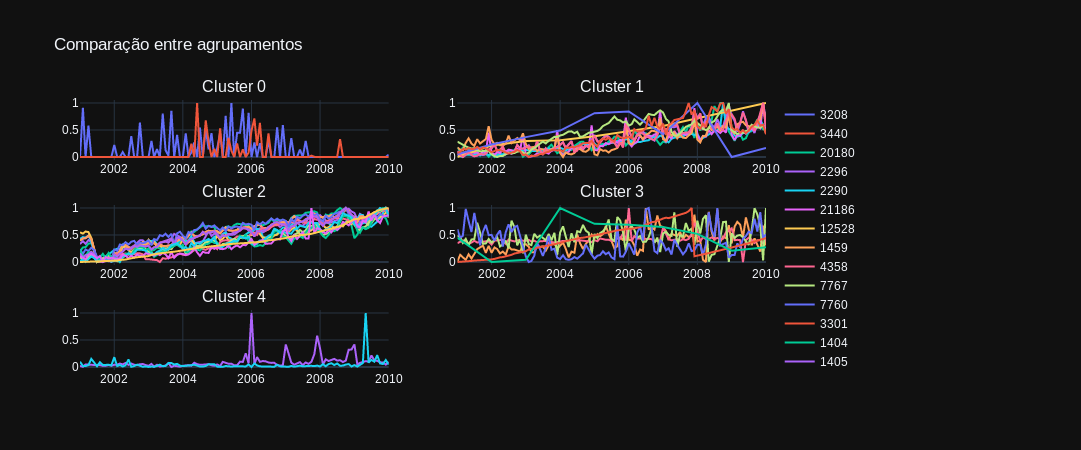

In [239]:
# for cluster_df in [c0,c1,c2,c3,c4]:
#     for cluster in ['0','1','2','3','4']:
#         for i in cluster_df.index:
#             temp_df = list_to_dtw[i]
#             trace = go.Scatter(x = temp_df['date'],
#                                y = normalize_list_numpy(temp_df[temp_df.columns[-1]]),
#                                name = cluster_df['code'][i],
#                                mode = 'lines')#, marker = dict(color = color_list[c]))
#             data.append(trace)
from plotly import tools

fig = tools.make_subplots(rows=3, cols=2, subplot_titles=('Cluster 0','Cluster 1', 'Cluster 2',
                                                          'Cluster 3', 'Cluster 4'))
for i in data0:
    fig.append_trace(i, 1, 1)
for i in data1:
    fig.append_trace(i, 1, 2)
for i in data2:
    fig.append_trace(i, 2, 1)
for i in data3:
    fig.append_trace(i, 2, 2)
for i in data4:
    fig.append_trace(i, 3, 1)

fig['layout'].update(title='Comparação entre agrupamentos', template = 'plotly_dark')
pyo.iplot(fig, filename='simple-subplot-with-annotations')